In [1]:
import os
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-05-22 23:18:49.979224: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 23:18:50.002954: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 23:18:50.116665: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 23:18:50.283960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747930730.500331   23867 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747930730.55

In [2]:
# Dataset and Model Parameters
dataset_handle = "arjuntejaswi/plant-village"
dataset_folder_name = "PlantVillage"
img_height, img_width = 128, 128
batch_size = 32
num_epochs = 25
learning_rate = 0.0001
validation_split = 0.2

# File path for saving the best model
best_model_filepath = "best_model.keras"

# Seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
os.environ["PYTHONHASHSEED"] = str(random_seed)

In [3]:
print(f"Downloading dataset: {dataset_handle}...")

download_path = Path(kagglehub.dataset_download(dataset_handle))
print(f"Dataset downloaded to base path: {download_path}")

# Construct the path to the actual image folder
data_dir = download_path / dataset_folder_name

Dataset downloaded to base path: /home/patuh/.cache/kagglehub/datasets/arjuntejaswi/plant-village/versions/1


In [4]:
# Initialize ImageDataGenerator with data augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split,
)

# Training data generator
train_generator = datagen.flow_from_directory(
    str(data_dir),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    seed=random_seed,
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    str(data_dir),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    seed=random_seed,
)

num_classes = train_generator.num_classes
print(
    f"Found {train_generator.samples} images for training belonging to {num_classes} classes."
)
print(f"Found {validation_generator.samples} images for validation.")

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Found 16516 images for training belonging to 15 classes.
Found 4122 images for validation.


In [5]:
# Load MobileNetV2 as the base model
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(img_height, img_width, 3),
)

base_model.trainable = False

# Create a new model on top of the base model
model = models.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Print a summary of the model
model.summary()

2025-05-22 23:18:59.399151: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Callback to save the best model during training
checkpoint_callback = ModelCheckpoint(
    filepath=best_model_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1,
)

# Callback for early stopping if validation accuracy doesn't improve
early_stopping_callback = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=0.000001,
    verbose=1,
)

# List of callbacks to use during training
callbacks_list = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [7]:
# Train Model
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list,
)

/home/patuh/dev/Capstone-LaskarAI/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.2864 - loss: 2.3363

/home/patuh/dev/Capstone-LaskarAI/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.67855, saving model to best_model.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 150s 283ms/step - accuracy: 0.2866 - loss: 2.3354 - val_accuracy: 0.6786 - val_loss: 1.1348 - learning_rate: 1.0000e-04
Epoch 2/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5917 - loss: 1.2907
Epoch 2: val_accuracy improved from 0.67855 to 0.74697, saving model to best_model.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 132s 254ms/step - accuracy: 0.5918 - loss: 1.2905 - val_accuracy: 0.7470 - val_loss: 0.8532 - learning_rate: 1.0000e-04
Epoch 3/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6646 - loss: 1.0524
Epoch 3: val_accuracy improved from 0.74697 to 0.77681, saving model to best_model.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 143s 277ms/step - accuracy: 0.6646 - loss: 1.0523 - val_accuracy: 0.7768 - val_loss: 0.7278 - learning_rate: 1.0000e-04
Epoch 4/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7075 - loss: 0.9105
Epoch 4: val_accuracy im

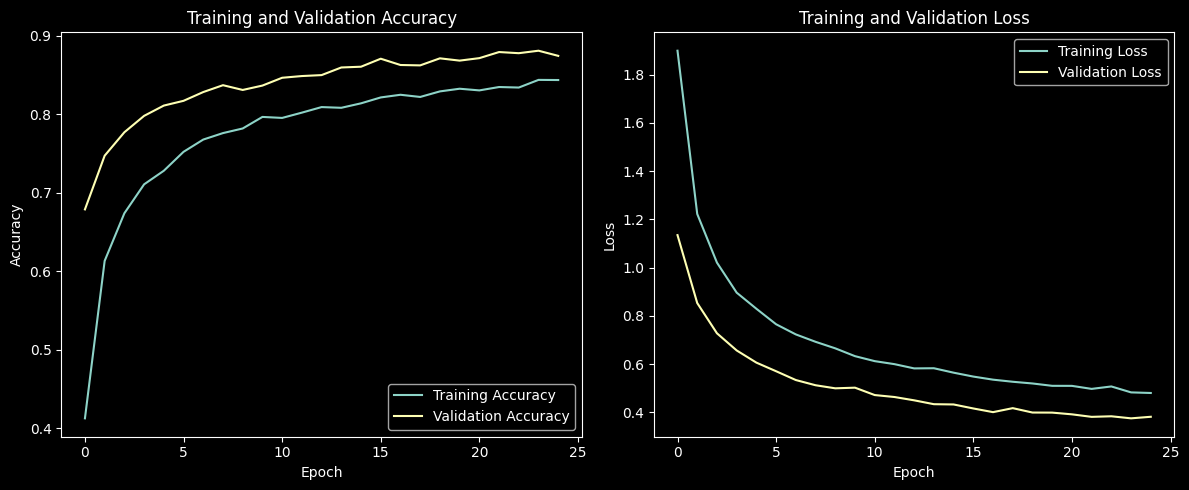

In [8]:
# Plot Training History
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
if acc and val_acc:
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
if loss and val_loss:
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()